# Notebook for demonstrative example

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [84]:
import numpy as np
import pickle as pkl
import torch
import pandas as pd
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.tableau import Tableau_20

from SignalTransformData.data_modules.simulated import SinusoidalDataModule
from WaveletVAE.src.WaveLSTM.models.base import WaveletBase
from WaveletVAE.experiments.demo.demo_config import get_demo_config

sns.set()
# sns.set_palette(Tableau_20.mpl_colors)
sns.set_palette(sns.color_palette("Paired"))


# Get data

In [2]:
config = get_demo_config()
classes = len(config["bias"])
channels = len(config["bias"][0])
length = 512
print(f"{classes} classes, with C={channels} channels and width W={length}")

dm = SinusoidalDataModule(config, samples=2000, batch_size=128, sig_length=length)
lbl, lbl_idx = np.unique(dm.labels, return_index=True)

# Plotting data (noise free)
X = dm.signals_no_noise[lbl_idx, :].reshape((6, -1))

6 classes, with C=2 channels and width W=512


### and put into a dataframe for Seaborn

In [3]:
data = []

# Class 1 and 2
# No distinction in resolution sources
for res in ["Low-resolution", "Mid-resolution", "High-resolution"]:
    for cls in [0, 1]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])

# Class 3 and 4
# Distinction at middle resolution
for res in ["Low-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[2, i]])
for res in ["Mid-resolution", "High-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])
            
# Class 5 and 6
# Distinction at high resolution
for res in ["Low-resolution", "Mid-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[4, i]])
for res in ["High-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])
            
df = pd.DataFrame(data, columns=["loci", "resolution", "class", "signal"])
df.head()            

,loci,resolution,class,signal
0,0,Low-resolution,1,0.000000
1,1,Low-resolution,1,-0.000009
2,2,Low-resolution,1,-0.000038
3,3,Low-resolution,1,-0.000085
4,4,Low-resolution,1,-0.000151


### Plot data

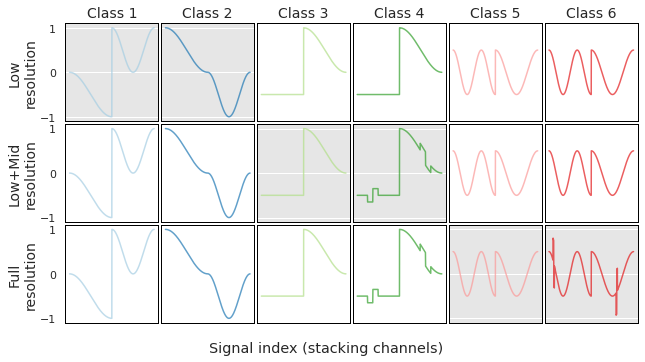

In [85]:
g = sns.FacetGrid(df, col="class", row="resolution", hue="class", margin_titles=True, despine=False, height=2, aspect=0.8)
g.map(sns.lineplot, "loci", "signal", alpha=.7)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="Class {col_name}", row_template="", size=14)    # {row_name}

for ax,l in zip(g.axes[:,0], ["Low\nresolution", "Low+Mid\nresolution", "Full\nresolution"]):
    ax.set_ylabel(l, fontsize=14, rotation=90)  #      ha='right', va='center', fontweight='bold'
    ax.yaxis.set_label_coords(-0.3, 0.5)

    
g.set_xlabels(label="", clear_inner=True, )
g.fig.supxlabel("Signal index (stacking channels)")

for ax in g.axes.flatten():
    for _, spine in ax.spines.items():
        spine.set_visible(True) 
        spine.set_color('black')
        spine.set_linewidth(1)
        
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Low-resolution" and (col_val == 1 or col_val == 2):
        ax.set_facecolor(".9")
    elif row_val == "Mid-resolution" and (col_val == 3 or col_val == 4):
        ax.set_facecolor(".9")
    elif row_val == "High-resolution" and (col_val == 5 or col_val == 6):
        ax.set_facecolor(".9")
    else:
        ax.set_facecolor((0, 0, 0, 0))
    ax.set_xticks([])


# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
plt.gcf().set_size_inches(9, 5)
plt.savefig("demo_data.png", dpi=500, format='png')

# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.

Replace log file to view the same plots for other model types

    Attentive autoencoder:
         "../logs/a-ae-output.pkl"
    Attentive classifier:
         "../logs/clf-output.pkl"

In [5]:
# with open("../logs/a-ae-output.pkl", 'rb') as file:
with open("../logs/clf-output.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
lbls = meta_results["labels"].cpu().numpy()
Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
A = meta_results["attention"]
print(f"Available outputs: {[i for i in meta_results.keys()]}")

Available outputs: ['masked_inputs', 'masked_targets', 'resolution_embeddings', 'attention', 'M', 'labels']


# Source-separation module

Visualise the source-separated inputs.

Any discrete wavelet can be used. We used the Haar wavelet throughout for simplicity, but different wavelets may suit different tasks.

Original (noise-free) input signal


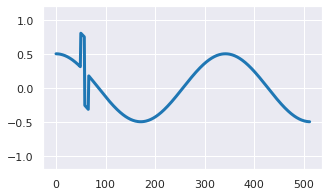

Source-separated input signals


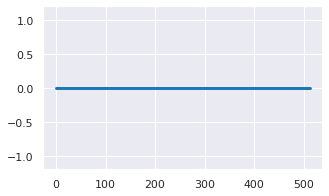

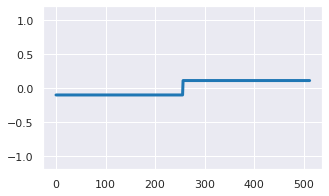

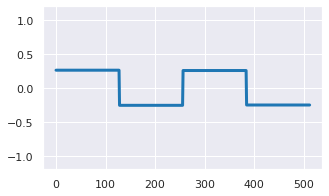

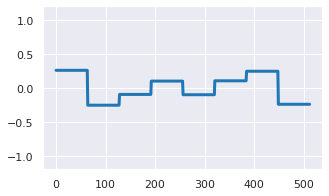

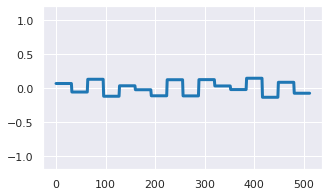

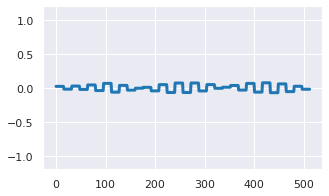

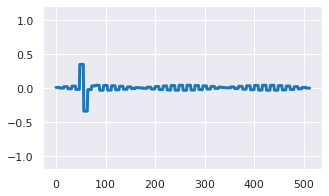

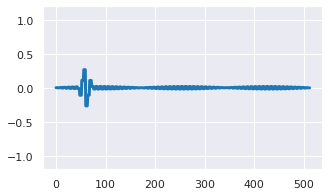

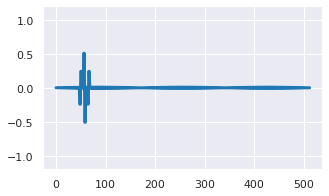

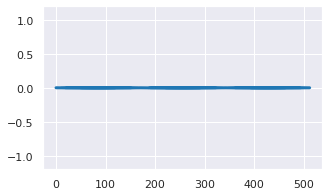

In [6]:
channel = 1                  # 1 or 2
cls = 6                      # 1,2,...,6
discrete_wavelet = "haar"    # supported discrete examples: "haar", "dbN", "symN", "biorN", "rbioN","dmey"
                             # We use a PyTorch extension of the pywt package which should support discrete wavelets found here:
                             #       https://pywavelets.readthedocs.io/en/latest/regression/wavelet.html
paper = False                # paper-ready plots

X = dm.signals_no_noise[lbl_idx, :]
loci = X.shape[-1]

print("Original (noise-free) input signal")
plt.figure(figsize=(5,3))
plt.plot(np.linspace(0, loci, loci), X[cls-1, channel-1, :], lw=3)
if paper:
    plt.xticks([]); plt.yticks([])
    plt.savefig(f"input_c{channel}.png", dpi=500, format='png', transparent=True); 
else:
    plt.ylim((-1.2,1.2))
plt.show()

print("Source-separated input signals")
wavelet_reducer = WaveletBase(X.shape[-1], wavelet=discrete_wavelet)
masked_inputs, _ = wavelet_reducer.sequence_mask(torch.from_numpy(X))
loci = masked_inputs[0].shape[-1]
for j in range(len(masked_inputs)):
    plt.figure(figsize=(5,3))
    plt.plot(np.linspace(0, loci, loci), masked_inputs[j].cpu().numpy()[cls-1, channel-1, :], lw=3)
    if paper:
        plt.xticks([]); plt.yticks([])
        plt.savefig(f"source_sep_input_c{channel}j{j+1}.png", dpi=500, format='png', transparent=True)
    else:
        plt.ylim((-1.2,1.2))


# Visualise Wave-LSTM encoder output

In [7]:
reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP()
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
else:
    raise NotImplementedError

# axis labels
latent1 = f"{reduce_method}-1"
latent2 = f"{reduce_method}-2"

## Resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

In [174]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["h_j", "X_j"]):

        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, lbls[i] + 1,
                         False if lbls[i] % 2 == 0 else True
                        ])  

df_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "resolution", "Class", "Artifact"])
display(df_emb.head())


,tSNE-1,tSNE-2,source,resolution,Class,Artifact
0,-21.493923,15.981978,h_j,1,2,True
1,6.773888,13.155465,h_j,1,5,False
2,-4.314173,-14.119568,h_j,1,4,True
3,-4.899868,-13.650589,h_j,1,4,True
4,10.153746,19.076683,h_j,1,6,True


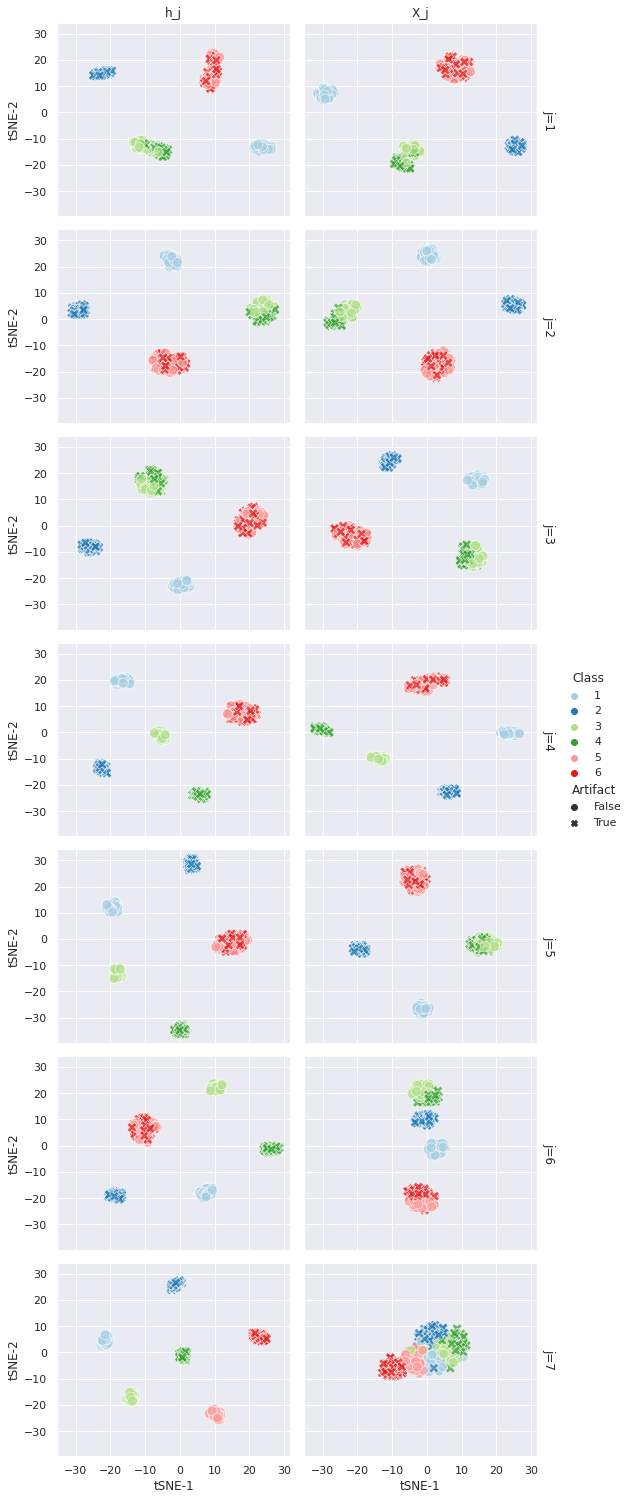

In [175]:

# # Plot
# g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="Class",
#                   margin_titles=True, despine=False,
#                   height=3, aspect=4/3, sharex=False, sharey=False)
# g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
# sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
# g.set_titles(row_template="j={row_name}", col_template="{col_name}")
# plt.show()

g = sns.relplot(data=df_emb, x=latent1, y=latent2,  row="resolution", col="source", hue="Class", 
                style="Artifact", style_order=[False, True],
                legend="auto", s=100, alpha=0.7,
                height=3, aspect=4/3,
                palette="Paired",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}", col_template="{col_name}")
plt.show()


We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.


## Plot selective resolution embeddings (paper plot)

This is the paper plot version of the above section

['$X_{j=2}$', '$X_{j=4}$', '$X_{j=5}$', '$X_{j=7}$', '$h_{j=2}$', '$h_{j=4}$', '$h_{j=5}$', '$h_{j=7}$']


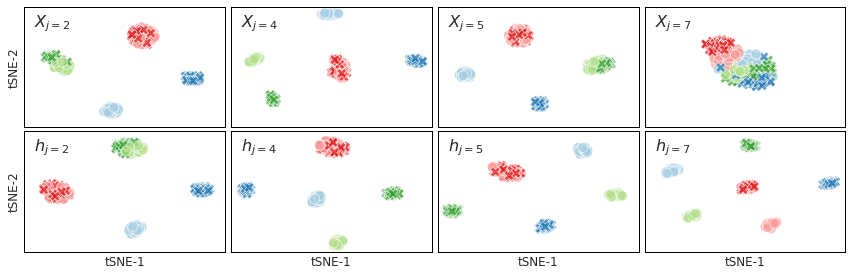

In [138]:
resolutions = [2,4,5,7]         # 1,2,3,...,J=7
sources = ["X_j", "h_j"]

df_fig2 = df_emb[df_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
# df_fig2 = df_fig2[df_fig2["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.relplot(data=df_fig2, x=latent1, y=latent2,  row="source", col="resolution", hue="Class", 
                row_order=sources,
                style="Artifact", style_order=[False, True],
                legend=False, s=100, alpha=0.7,
                height=2, aspect=1.5,
                palette="Paired",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True)
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True)

spaces = []
tmp1 = r"_{j="
tmp2 = r"}"
[[ spaces.append(f"${i[0]}{tmp1}{j}{tmp2}$") for j in resolutions] for i in sources] 
# spaces = [[ for j in resolutions] for i in sources].flatten()
print(spaces)
for ax, space in zip(g.axes.flatten(), spaces ):  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))
    
    if j is not None:
        ax.text(.05, .95, f'{space}', ha='left', va='top', transform=ax.transAxes, size=16)

    
# for ax,l in zip(g.axes[:,0], sources):
#         ax.set_ylabel(l, fontweight='bold', fontsize=18, rotation=0, ha='right', va='center')


# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig("resolution_embeddings.png", dpi=500, format='png', transparent=True)

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

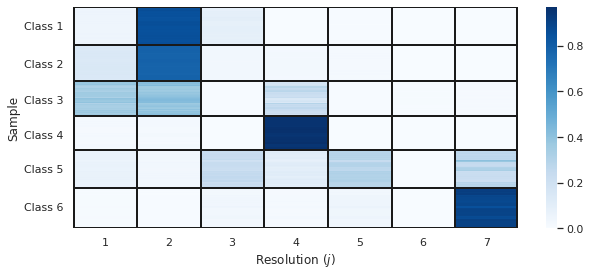

In [139]:
# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = torch.mean(ord_attention, dim=1).cpu().numpy()  

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(ord_attention.shape[1], 1), method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9,4))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Add horizontal lines
y_tick_locations = [np.where(ord_lbls == _lbl)[0][0] for _lbl in np.unique(ord_lbls)]
for y_tick in y_tick_locations:
    ax.hlines(y=y_tick+0.1, xmin=0, xmax=20, linewidth=2, color='k')
ax.hlines(y=attention.shape[0]-0.1, xmin=0, xmax=20, linewidth=2, color='k')

# Add vertical lines
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

    
ax.set_yticks([yi+attention.shape[0]/12 for yi in y_tick_locations])
# ax.set_yticks([], minor=True)
# ax.yaxis.grid(True, which='major', lw=1, ls='-', color='k')
ax.set_yticklabels([f"Class {i+1}" for i in np.unique(ord_lbls)])
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Sample")    # permuted

plt.tight_layout()
plt.savefig("attention.png", dpi=500, format='png', transparent=True)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

,tSNE-1,tSNE-2,source,Class,Artifact
0,2.674418,-23.907784,Mflat,2,True
1,2.548877,-1.876260,Mflat,5,False
2,-17.627962,10.326359,Mflat,4,True
3,-16.117334,10.728082,Mflat,4,True
4,4.751764,24.682293,Mflat,6,True


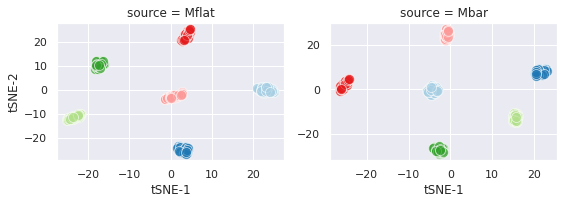

In [149]:
data = []

for Mvar, Mname in zip([Mflat, Mbar], ["Mflat", "Mbar"]):

    embedding = reducer.fit_transform(Mvar.reshape((Mvar.shape[0], -1)))

    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     Mname,
                     lbls[i] + 1,
                     False if lbls[i] % 2 == 0 else True
                    ])  

df_mres_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "Class", "Artifact"])
display(df_mres_emb.head())

# Plot
g = sns.FacetGrid(df_mres_emb, col="source", hue="Class", 
                  margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


## Plot flattened multi-resolution embeddings (in paper)

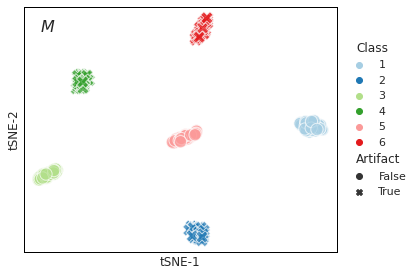

In [173]:
sources = ["Mflat"]

df_mres_emb = df_mres_emb[df_mres_emb["source"].isin(sources)]
# df_mres_emb = df_mres_emb[df_mres_emb["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.relplot(data=df_mres_emb, x=latent1, y=latent2,  col="source", hue="Class", 
                row_order=sources,
                style="Artifact", style_order=[False, True],
                legend=True, s=150, alpha=0.7,
                height=4, aspect=1,
                palette="Paired",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")

leg = g._legend
leg.set_bbox_to_anchor([0.95, 0.85])
leg._loc = 2 

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=latent1, clear_inner=True)
g.set_ylabels(label=latent2, clear_inner=True)

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, r'$M$', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
        
plt.savefig("multires_emb_flat.png", dpi=500, format='png', bbox_inches='tight', transparent=True)